<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip   
else:
    print("El dataset ya se encuentra descargado")

--2023-05-03 01:42:00--  http://songs_dataset.zip/
Resolving songs_dataset.zip (songs_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘songs_dataset.zip’
--2023-05-03 01:42:01--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2023-05-03 01:42:01--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (

In [3]:
# Posibles bandas
os.listdir("./songs_dataset/")

['dickinson.txt',
 'janisjoplin.txt',
 'dolly-parton.txt',
 'Kanye_West.txt',
 'bruno-mars.txt',
 'r-kelly.txt',
 'bjork.txt',
 'al-green.txt',
 'michael-jackson.txt',
 'blink-182.txt',
 'nirvana.txt',
 'radiohead.txt',
 'amy-winehouse.txt',
 'nickelback.txt',
 'ludacris.txt',
 'kanye.txt',
 'lorde.txt',
 'rihanna.txt',
 'bob-marley.txt',
 'drake.txt',
 'lady-gaga.txt',
 'dj-khaled.txt',
 'notorious-big.txt',
 'nursery_rhymes.txt',
 'bruce-springsteen.txt',
 'patti-smith.txt',
 'lin-manuel-miranda.txt',
 'nicki-minaj.txt',
 'paul-simon.txt',
 'cake.txt',
 'notorious_big.txt',
 'beatles.txt',
 'alicia-keys.txt',
 'missy-elliott.txt',
 'britney-spears.txt',
 'disney.txt',
 'Lil_Wayne.txt',
 'bieber.txt',
 'leonard-cohen.txt',
 'eminem.txt',
 'joni-mitchell.txt',
 'adele.txt',
 'lil-wayne.txt',
 'jimi-hendrix.txt',
 'dr-seuss.txt',
 'kanye-west.txt',
 'bob-dylan.txt',
 'johnny-cash.txt',
 'prince.txt']

In [4]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
# Se usa el dataset de Radiohead
df = pd.read_csv('songs_dataset/radiohead.txt', sep='/n', header=None)
df.head()

<ipython-input-4-48474518626e>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/radiohead.txt', sep='/n', header=None)


,0
0,"Come on, come on"
1,You think you drive me crazy
2,"Come on, come on"
3,You and whose army?
4,You and your cronies


In [5]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 2343


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [6]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [10]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[1,0]
text

'You think you drive me crazy'

In [11]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['you', 'think', 'you', 'drive', 'me', 'crazy']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [12]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [13]:
# Demos un vistazo
sentence_tokens[:4]

[['come', 'on', 'come', 'on'],
 ['you', 'think', 'you', 'drive', 'me', 'crazy'],
 ['come', 'on', 'come', 'on'],
 ['you', 'and', 'whose', 'army']]

In [14]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [15]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[['you', 'think', 'you', 'drive'], ['think', 'you', 'drive', 'me']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [16]:
tok = Tokenizer() 

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [17]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[1, 2, 1, 3], [2, 1, 3, 4]]

In [18]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

2


In [19]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

4


In [20]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'you': 1, 'think': 2, 'drive': 3, 'me': 4}


In [21]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'drive': 2, 'you': 2, 'think': 2, 'me': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [23]:
# Vistazo a las primeras filas
df.loc[:20,0]

0                 Come on, come on
1     You think you drive me crazy
2                 Come on, come on
3              You and whose army?
4             You and your cronies
5                 Come on, come on
6                Holy Roman empire
7             Come on if you think
8             Come on if you think
9               You can take us on
10              You can take us on
11             You and whose army?
12            You and your cronies
13            You forget so easily
14                 We ride tonight
15                 We ride tonight
16                    Ghost horses
17                    Ghost horses
18                 We ride tonight
19                 We ride tonight
20                    Ghost horses
Name: 0, dtype: object

In [24]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

"Come on, come on You think you drive me crazy Come on, come on You and whose army? You and your cronies Come on, come on Holy Roman empire Come on if you think Come on if you think You can take us on You can take us on You and whose army? You and your cronies You forget so easily We ride tonight We ride tonight Ghost horses Ghost horses We ride tonight We ride tonight Ghost horses Ghost horses Ghost horses I sail to the moon I spoke too soon And how much did it cost I was dropped from Moonbeam And sailed on shooting stars Maybe you'll Be president But know right from wrong Or in the flood You'll build an Ark And sail us to the moon Sail us to the moon Sail us to the moon Something for the rag and bone man Over my dead body Something big is gonna happen Over my dead body Someone's son or someone's daughter Over my dead body This is how I end up sucked in Over my dead body I'm gonna go to sleep Let this wash all over me We don't really want a monster taking over Tiptoe around, tie him d

In [25]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['come',
 'on',
 'come',
 'on',
 'you',
 'think',
 'you',
 'drive',
 'me',
 'crazy',
 'come',
 'on',
 'come',
 'on',
 'you',
 'and',
 'whose',
 'army',
 'you',
 'and']

In [26]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 11803


In [27]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [28]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['come', 'on', 'come', 'on'],
 ['on', 'come', 'on', 'you'],
 ['come', 'on', 'you', 'think'],
 ['on', 'you', 'think', 'you'],
 ['you', 'think', 'you', 'drive'],
 ['think', 'you', 'drive', 'me'],
 ['you', 'drive', 'me', 'crazy'],
 ['drive', 'me', 'crazy', 'come'],
 ['me', 'crazy', 'come', 'on'],
 ['crazy', 'come', 'on', 'come'],
 ['come', 'on', 'come', 'on'],
 ['on', 'come', 'on', 'you'],
 ['come', 'on', 'you', 'and'],
 ['on', 'you', 'and', 'whose'],
 ['you', 'and', 'whose', 'army'],
 ['and', 'whose', 'army', 'you'],
 ['whose', 'army', 'you', 'and'],
 ['army', 'you', 'and', 'your'],
 ['you', 'and', 'your', 'cronies'],
 ['and', 'your', 'cronies', 'come']]

In [29]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[47, 13, 47, 13],
 [13, 47, 13, 2],
 [47, 13, 2, 82],
 [13, 2, 82, 2],
 [2, 82, 2, 915],
 [82, 2, 915, 7],
 [2, 915, 7, 492],
 [915, 7, 492, 47],
 [7, 492, 47, 13],
 [492, 47, 13, 47],
 [47, 13, 47, 13],
 [13, 47, 13, 2],
 [47, 13, 2, 4],
 [13, 2, 4, 617],
 [2, 4, 617, 618],
 [4, 617, 618, 2],
 [617, 618, 2, 4],
 [618, 2, 4, 9],
 [2, 4, 9, 619],
 [4, 9, 619, 47]]

In [30]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 11799


### 3 - Input y target

In [31]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [32]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [33]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [34]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(11799, 3)
(11799,)


In [35]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'you',
 3: 'i',
 4: 'and',
 5: 'a',
 6: 'to',
 7: 'me',
 8: 'in',
 9: 'your',
 10: 'it',
 11: "don't",
 12: 'all',
 13: 'on',
 14: 'is',
 15: "i'm",
 16: 'of',
 17: 'up',
 18: 'out',
 19: 'no',
 20: 'be',
 21: 'my',
 22: 'we',
 23: 'what',
 24: 'will',
 25: "it's",
 26: 'not',
 27: 'just',
 28: 'can',
 29: 'this',
 30: 'down',
 31: 'that',
 32: 'are',
 33: 'want',
 34: 'do',
 35: 'get',
 36: 'know',
 37: 'with',
 38: 'so',
 39: 'but',
 40: 'where',
 41: 'like',
 42: 'if',
 43: 'for',
 44: 'alive',
 45: 'one',
 46: 'now',
 47: 'come',
 48: 'they',
 49: 'back',
 50: 'here',
 51: 'take',
 52: 'oh',
 53: 'off',
 54: "you're",
 55: 'there',
 56: "i'll",
 57: 'see',
 58: 'again',
 59: 'hurt',
 60: 'from',
 61: 'am',
 62: 'eat',
 63: 'should',
 64: 'when',
 65: 'around',
 66: 'more',
 67: 'got',
 68: 'really',
 69: 'at',
 70: 'let',
 71: 'lies',
 72: 'have',
 73: 'love',
 74: 'as',
 75: 'rain',
 76: 'good',
 77: 'us',
 78: 'go',
 79: "there's",
 80: "there'll",
 81: 'yourself',

In [36]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

1715

In [37]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(11799, 1715)

### 4 - Entrenar el modelo

In [39]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [40]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

1715

In [47]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3, 5)              8580      
                                                                 
 lstm_3 (LSTM)               (None, 3, 64)             17920     
                                                                 
 dropout_2 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_4 (LSTM)               (None, 3, 64)             33024     
                                                                 
 dropout_3 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_5 (LSTM)               (None, 3, 64)             33024     
                                                                 
 dropout_4 (Dropout)         (None, 3, 64)            

In [48]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
295/295 [==============================] - 15s 27ms/step - loss: 6.3528 - accuracy: 0.0433 - val_loss: 6.4582 - val_accuracy: 0.0479
Epoch 2/50
295/295 [==============================] - 4s 13ms/step - loss: 5.9329 - accuracy: 0.0475 - val_loss: 6.6909 - val_accuracy: 0.0479
Epoch 3/50
295/295 [==============================] - 4s 14ms/step - loss: 5.8783 - accuracy: 0.0463 - val_loss: 6.6434 - val_accuracy: 0.0479
Epoch 4/50
295/295 [==============================] - 4s 12ms/step - loss: 5.8481 - accuracy: 0.0464 - val_loss: 6.8453 - val_accuracy: 0.0237
Epoch 5/50
295/295 [==============================] - 4s 13ms/step - loss: 5.8248 - accuracy: 0.0461 - val_loss: 6.8293 - val_accuracy: 0.0424
Epoch 6/50
295/295 [==============================] - 5s 16ms/step - loss: 5.7857 - accuracy: 0.0498 - val_loss: 6.9498 - val_accuracy: 0.0398
Epoch 7/50
295/295 [==============================] - 4s 12ms/step - loss: 5.6952 - accuracy: 0.0532 - val_loss: 6.9291 - val_accuracy: 0.041

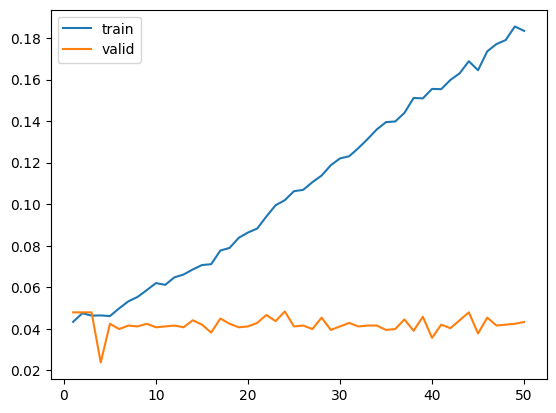

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [44]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [45]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.7/286.7 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.1 MB/s eta 0

In [46]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    print("Texto ingresado:", human_text,"- Predicción:", out_word)
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 1s 1s/step
Texto ingresado: ghost - Predicción: i
1/1 [==============================] - 0s 20ms/step
Texto ingresado: you - Predicción: i
1/1 [==============================] - 0s 20ms/step
Texto ingresado: will - Predicción: the
1/1 [==============================] - 0s 22ms/step
Texto ingresado: all - Predicción: great
1/1 [==============================] - 0s 20ms/step
Texto ingresado: come - Predicción: i
1/1 [==============================] - 0s 19ms/step
Texto ingresado: broken - Predicción: eyes
1/1 [==============================] - 0s 21ms/step
Texto ingresado: hearts - Predicción: the
Keyboard interruption in main thread... closing server.


### 7 - Conclusion
- La metrica accuracy tiene a mejorar pero la metrica loss empeora.
- En la validación el modelo no mejora.
- Se ralizaron pruebas con palabras que se repiten bastante en la canción y, en su mayoría, no coicidió con la palabra que sigue.


### Prueba de arquitectura mejorada
Se le pide a Chat GPT que proponga una arquitectura mejorada para la anterior y responde lo siguiente:

  "Aquí hay algunas posibles mejoras que se pueden hacer a esta arquitectura de red para mejorar la métrica de accuracy:

Regularización adicional: Además de la capa Dropout existente, se puede agregar regularización L2 o L1 a las capas LSTM y densas para reducir aún más el sobreajuste.

Batch normalization: Agregar capas de normalización por lotes (batch normalization) entre las capas LSTM y densas puede ayudar a estabilizar la salida de cada capa y mejorar la convergencia del modelo.

Aumentar el número de unidades en las capas LSTM: Aumentar el número de unidades en las capas LSTM puede ayudar a que la red capture patrones más complejos en los datos.

Añadir capas de atención: Agregar capas de atención a la red puede ayudar a la red a centrarse en las partes importantes de las secuencias de entrada y mejorar su capacidad para predecir la siguiente palabra o caracter.

Utilizar técnicas de aprendizaje semi-supervisado: Si se tiene una gran cantidad de datos no etiquetados, se pueden utilizar técnicas de aprendizaje semi-supervisado para mejorar el rendimiento de la red. Por ejemplo, se puede utilizar un modelo de lenguaje previamente entrenado para inicializar los pesos de la red y mejorar su capacidad para capturar patrones en los datos."

Y es la red que se prueba a continuación.

In [55]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, BatchNormalization, Attention
from keras.regularizers import l2

model1 = Sequential()
model1.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

# Capa LSTM con regularización L2 y batch normalization
model1.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))

# Capa LSTM con regularización L2 y atención
model1.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)))
#model1.add(Attention())
model1.add(Dropout(0.3))

# Capa LSTM con regularización L2 y batch normalization
model1.add(LSTM(128, kernel_regularizer=l2(0.01)))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))

# Capa densa con regularización L2 y batch normalization
model1.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))

# Capa de salida
model1.add(Dense(vocab_size, activation='softmax'))

# Compilar el modelo
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Imprimir un resumen del modelo
model1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 3, 5)              8580      
                                                                 
 lstm_18 (LSTM)              (None, 3, 128)            68608     
                                                                 
 batch_normalization_10 (Bat  (None, 3, 128)           512       
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 3, 128)            0         
                                                                 
 lstm_19 (LSTM)              (None, 3, 128)            131584    
                                                                 
 dropout_19 (Dropout)        (None, 3, 128)            0         
                                                      

In [59]:
hist = model1.fit(x_data, y_data, epochs=50, validation_split=0.3)

Epoch 1/50
259/259 [==============================] - 5s 18ms/step - loss: 3.5609 - accuracy: 0.2825 - val_loss: 8.6581 - val_accuracy: 0.0864
Epoch 2/50
259/259 [==============================] - 4s 16ms/step - loss: 3.5444 - accuracy: 0.2735 - val_loss: 8.7380 - val_accuracy: 0.0881
Epoch 3/50
259/259 [==============================] - 4s 16ms/step - loss: 3.5865 - accuracy: 0.2672 - val_loss: 8.8386 - val_accuracy: 0.0886
Epoch 4/50
259/259 [==============================] - 4s 15ms/step - loss: 3.5217 - accuracy: 0.2768 - val_loss: 8.6915 - val_accuracy: 0.0996
Epoch 5/50
259/259 [==============================] - 4s 15ms/step - loss: 3.5528 - accuracy: 0.2688 - val_loss: 8.6364 - val_accuracy: 0.0907
Epoch 6/50
259/259 [==============================] - 4s 14ms/step - loss: 3.4819 - accuracy: 0.2816 - val_loss: 8.7740 - val_accuracy: 0.0894
Epoch 7/50
259/259 [==============================] - 5s 18ms/step - loss: 3.4982 - accuracy: 0.2689 - val_loss: 8.6668 - val_accuracy: 0.1034

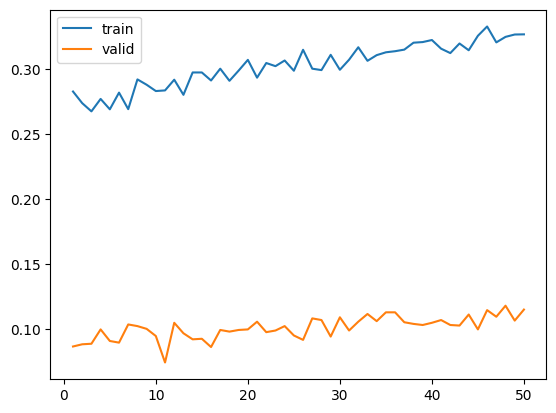

In [60]:
# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [61]:
import sys
!{sys.executable} -m pip install gradio --quiet

In [62]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model1.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    print("Texto ingresado:", human_text,"- Predicción:", out_word)
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 2s 2s/step
Texto ingresado: let - Predicción: your
1/1 [==============================] - 0s 30ms/step
Texto ingresado: broken - Predicción: and
1/1 [==============================] - 0s 24ms/step
Texto ingresado: before - Predicción: on
1/1 [==============================] - 0s 22ms/step
Texto ingresado: just - Predicción: on
1/1 [==============================] - 0s 21ms/step
Texto ingresado: all - Predicción: 
1/1 [==============================] - 0s 29ms/step
Texto ingresado: will - Predicción: the
Keyboard interruption in main thread... closing server.


###Conclusión:
 - No se evidenciaron mejoras en las metricas
 - Se realizaron pruebas con palabras y se obtienen resultados similares